# `CNModel` Tutorial

Trey V. Wenger (c) December 2024

Here we demonstrate the basic features of the `CNModel` model. The `CNModel` models the hyperfine spectral structure of ${\rm CN}$ and $^{13}{\rm CN}$ including non-LTE effects. Please review the `bayes_spec` documentation and tutorials for a more thorough description of the steps outlined in this tutorial: https://bayes-spec.readthedocs.io/en/stable/index.html

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+5.gba85b08.dirty


## `get_molecule_data`

Here we model the hyperfine structure of CN emission. We use the helper function `get_molecule_data` to download the molecular data for this molecule.

In [2]:
from bayes_cn_hfs import get_molecule_data
import astropy.constants as c

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
print(mol_data_12CN.keys())
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Upper state degrees of freedom:", mol_data_12CN['degu'])
print("Lower state energy level (erg)", mol_data_12CN['El'])
print("Upper state energy level (erg)", mol_data_12CN['Eu'])
print("Relative intensities", mol_data_12CN['relative_int'])
print("Partition function terms:", mol_data_12CN["log10_Q_terms"])
print("Upper state quantum numbers:", mol_data_12CN["Qu"])
print("lower states quantum numbers", mol_data_12CN["Ql"])

dict_keys(['freq', 'Aul', 'degu', 'El', 'Eu', 'relative_int', 'log10_Q_terms', 'Qu', 'Ql'])
transition frequency (MHz): [113123.3687 113144.19   113170.535  113191.325  113488.142  113490.985
 113499.643  113508.934  113520.4215]
Einstein A coefficient (s-1): [1.26969616e-06 1.03939111e-05 5.07869910e-06 6.59525390e-06
 6.64784064e-06 1.17706070e-05 1.04919208e-05 5.12459350e-06
 1.28243028e-06]
Upper state degrees of freedom: [2 2 4 4 4 6 2 4 2]
Lower state energy level (erg) [1.3905121e-19 0.0000000e+00 1.3905121e-19 0.0000000e+00 1.3905121e-19
 0.0000000e+00 1.3905121e-19 0.0000000e+00 0.0000000e+00]
Upper state energy level (erg) [7.49702428e-16 7.49701340e-16 7.50014955e-16 7.50013660e-16
 7.52119441e-16 7.51999228e-16 7.52195648e-16 7.52118159e-16
 7.52194276e-16]
Relative intensities [0.01204699 0.09860036 0.09633376 0.1250773  0.12574146 0.33394774
 0.09921527 0.09691221 0.01212491]
Partition function terms: [0.40307694 0.97433601]
Upper state quantum numbers: ['1 0 1 1', '1 0 

## Simulating Data

To test the model, we must simulate some data. We can do this with `CNModel`, but we must pack a "dummy" data structure first.

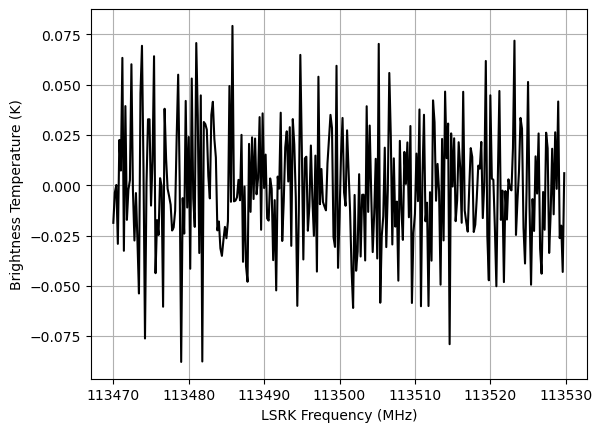

In [3]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(freq_axis)) # K

# CNModel datasets can be named anything, here we name it "observation"
observation = SpecData(
    freq_axis,
    brightness_data,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
# HACK: normalize data by noise
observation._brightness_offset = np.median(brightness_data)
observation._brightness_scale = observation.noise
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the model for a given set of parameters.

Transition 113144.19 is constraining upper state 3 from lower state 0
Transition 113191.325 is constraining upper state 0 from lower state 0
Transition 113490.985 is constraining upper state 2 from lower state 0
Transition 113508.934 is constraining upper state 1 from lower state 0
Transition 113520.4215 is constraining upper state 4 from lower state 0
Transition 113123.3687 is constraining lower state 1 from upper state 3
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]

Tex:
[[15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]
 [15.84893192 63.09573445 79.43282347]]

tau:
[[0

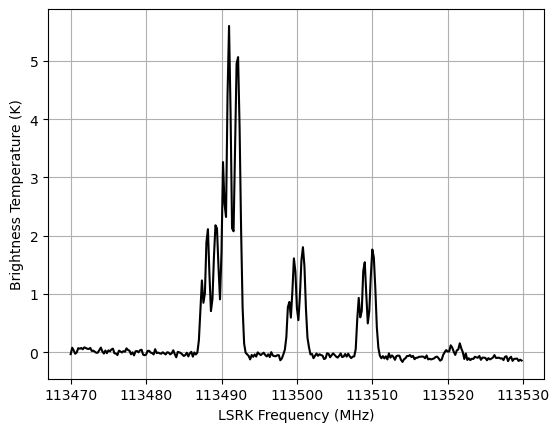

In [4]:
from bayes_cn_hfs.cn_model import CNModel

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 2 # polynomial baseline degree
model = CNModel(
    dummy_data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [13.0, 0.25], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = None, # ignored for this LTE model
    prior_log10_Tkin = [1.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log_boltz_factor_sigma = 0.0, # assume no hyperfine anomalies
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N0": [13.5, 13.2, 12.8],
    "log10_Tkin": [1.2, 1.8, 1.9],
    "fwhm_nonthermal": [2.0, 1.5, 1.0],
    "velocity": [-3.0, 0.0, 2.0],
    "fwhm_L": 0.0,
    "baseline_observation_norm": [-2.0, -5.0, 8.0],
}
sim_brightness = model.model.observation.eval(sim_params, on_unused_input="ignore")
Tex = model.model.Tex.eval(sim_params, on_unused_input="ignore")
tau = model.model.tau.eval(sim_params, on_unused_input="ignore")
tau_total = model.model.tau_total.eval(sim_params, on_unused_input="ignore")
log10_N = model.model.log10_N.eval(sim_params, on_unused_input="ignore")
derived_params = {"log10_N": log10_N, "tau_total": tau_total}

print()
print("Tex:")
print(Tex)

print()
print("tau:")
print(tau)

print()
print("tau_total:")
print(tau_total)

print()
print("log10_N:")
print(log10_N)

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
_ = plt.ylabel(dummy_data["observation"].ylabel)

In [5]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    freq_axis,
    sim_brightness,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel="Brightness Temperature (K)",
)
# HACK: normalize data by noise
observation._brightness_offset = np.median(sim_brightness)
observation._brightness_scale = observation.noise
data = {"observation": observation}

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `CNModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = CNModel(
    data,
    molecule="CN", # molecule (either "CN" or "13CN")
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N0 = [13.0, 0.25], # mean and width of log10 ground state column density prior (cm-2)
    prior_log10_Tex = None, # ignored for this LTE model
    prior_log10_Tkin = [1.75, 0.25], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume kinetic temperature = excitation temperature
    prior_log_boltz_factor_sigma = 0.0, # assume no hyperfine anomalies
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Transition 113144.19 is constraining upper state 3 from lower state 0
Transition 113191.325 is constraining upper state 0 from lower state 0
Transition 113490.985 is constraining upper state 2 from lower state 0
Transition 113508.934 is constraining upper state 1 from lower state 0
Transition 113520.4215 is constraining upper state 4 from lower state 0
Transition 113123.3687 is constraining lower state 1 from upper state 3
6/9 transitions used to constrain state densities
Free Tex transitions: [113123.3687 113144.19   113191.325  113490.985  113508.934  113520.4215]
Derived Tex transitions: [113170.535 113488.142 113499.643]


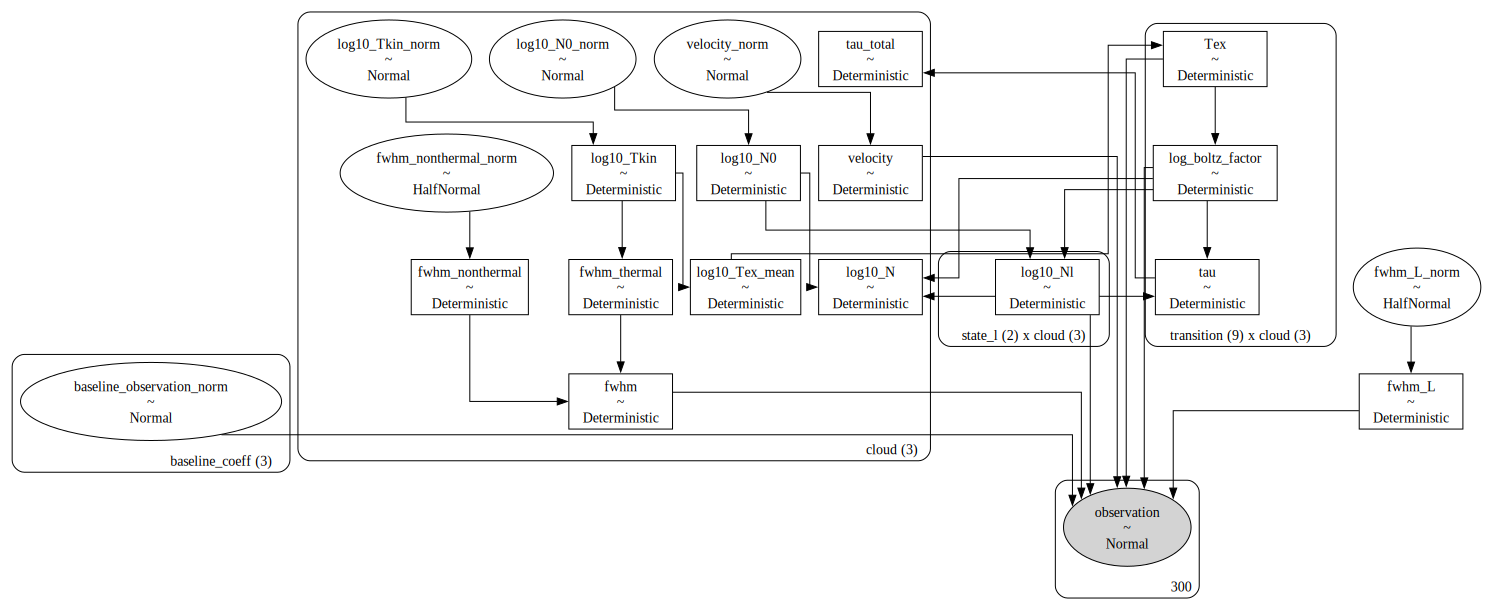

In [7]:
# Plot model graph
model.graph().render('cn_model', format='png')
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

baseline_observation_norm ~ Normal(0, <constant>)
            log10_N0_norm ~ Normal(0, 1)
          log10_Tkin_norm ~ Normal(0, 1)
            velocity_norm ~ Normal(0, 1)
     fwhm_nonthermal_norm ~ HalfNormal(0, 1)
              fwhm_L_norm ~ HalfNormal(0, 1)
                 log10_N0 ~ Deterministic(f(log10_N0_norm))
               log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
           log10_Tex_mean ~ Deterministic(f(log10_Tkin_norm))
                      Tex ~ Deterministic(f(log10_Tkin_norm))
         log_boltz_factor ~ Deterministic(f(log10_Tkin_norm))
                 log10_Nl ~ Deterministic(f(log10_N0_norm, log10_Tkin_norm))
                  log10_N ~ Deterministic(f(log10_N0_norm, log10_Tkin_norm))
                 velocity ~ Deterministic(f(velocity_norm))
             fwhm_thermal ~ Deterministic(f(log10_Tkin_norm))
          fwhm_nonthermal ~ Deterministic(f(fwhm_nonthermal_norm))
                     fwhm ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
  

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_observation_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N0_norm, log10_Tkin_norm, observation, velocity_norm]


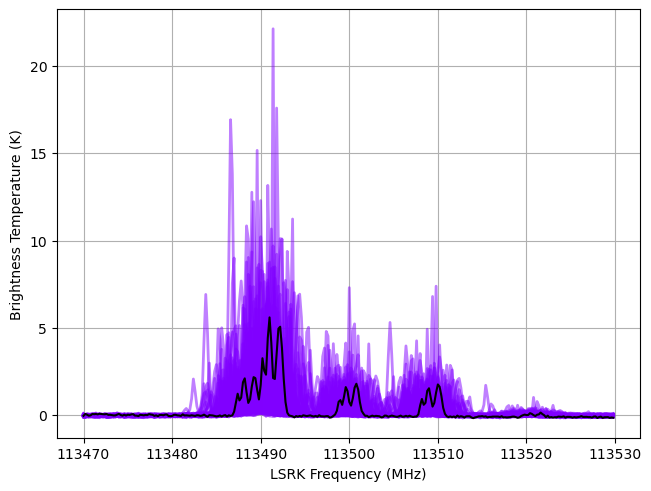

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.02, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = 10,487


Output()

Runtime: 0.27 minutes


In [11]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
log10_N0[0]                   13.501  0.002  13.498   13.504      0.000   
log10_N0[1]                   13.178  0.001  13.176   13.181      0.000   
log10_N0[2]                   12.810  0.003  12.803   12.816      0.000   
log10_Tkin[0]                  1.193  0.002   1.189    1.198      0.000   
log10_Tkin[1]                  2.033  0.023   1.991    2.078      0.001   
log10_Tkin[2]                  1.791  0.029   1.733    1.843      0.001   
log10_Tex_mean[0]              1.193  0.002   1.189    1.198      0.000   
log10_Tex_mean[1]              2.033  0.023   1.991    2.078      0.001   
log10_Tex_mean[2]              1.791  0.029   1.733    1.843      0.001   
log10_N[0]                    14.171  0.002  14.167   14.174      0.000   
log10_N[1]                    13.940  0.002  13.937   13.943      0.000   
log10_N[2]                    13.559  0.004  13.553   13.567      0.000   
velocity[0]                   -2.995  0.004  -3.003   -2.988      0.000   
velocity[1]                   -0.006  0.005  -0.015    0.002      0.000   
velocity[2]                    2.010  0.005   2.001    2.021      0.000   
fwhm_thermal[0]                0.166  0.000   0.165    0.167      0.000   
fwhm_thermal[1]                0.436  0.012   0.414    0.457      0.000   
fwhm_thermal[2]                0.330  0.011   0.309    0.350      0.000   
fwhm_nonthermal[0]             1.984  0.009   1.968    2.001      0.000   
fwhm_nonthermal[1]             1.489  0.008   1.474    1.502      0.000   
fwhm_nonthermal[2]             1.011  0.012   0.989    1.032      0.000   
fwhm[0]                        1.990  0.009   1.975    2.007      0.000   
fwhm[1]                        1.552  0.008   1.536    1.565      0.000   
fwhm[2]                        1.064  0.012   1.042    1.085      0.000   
tau_total[0]                   1.372  0.008   1.356    1.386      0.000   
tau_total[1]                   0.109  0.006   0.098    0.120      0.000   
tau_total[2]                   0.080  0.005   0.070    0.090      0.000   
fwhm_L                         0.015  0.009   0.003    0.030      0.000   
baseline_observation_norm[0]  -0.996  0.064  -1.122   -0.890      0.002   
baseline_observation_norm[1]  -4.629  0.226  -5.058   -4.230      0.007   
baseline_observation_norm[2]   1.448  0.952  -0.355    3.218      0.031   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
log10_N0[0]                     0.000    1025.0     986.0    NaN  
log10_N0[1]                     0.000     757.0     742.0    NaN  
log10_N0[2]                     0.000    1038.0     906.0    NaN  
log10_Tkin[0]                   0.000     972.0     863.0    NaN  
log10_Tkin[1]                   0.001     912.0     818.0    NaN  
log10_Tkin[2]                   0.001     979.0     939.0    NaN  
log10_Tex_mean[0]               0.000     972.0     863.0    NaN  
log10_Tex_mean[1]               0.001     912.0     818.0    NaN  
log10_Tex_mean[2]               0.001     979.0     939.0    NaN  
log10_N[0]                      0.000    1025.0    1022.0    NaN  
log10_N[1]                      0.000     832.0     865.0    NaN  
log10_N[2]                      0.000    1032.0     943.0    NaN  
velocity[0]                     0.000    1055.0    1021.0    NaN  
velocity[1]                     0.000     899.0     976.0    NaN  
velocity[2]                     0.000     971.0     938.0    NaN  
fwhm_thermal[0]                 0.000     972.0     863.0    NaN  
fwhm_thermal[1]                 0.000     912.0     818.0    NaN  
fwhm_thermal[2]                 0.000     979.0     939.0    NaN  
fwhm_nonthermal[0]              0.000     920.0     981.0    NaN  
fwhm_nonthermal[1]              0.000     778.0     843.0    NaN  
fwhm_nonthermal[2]              0.000     663.0     945.0    NaN  
fwhm[0]                         0.000     922.0     981.0    NaN  
fwhm[1]                         0.000     871.0     900.0    NaN  
fwhm[2]                

Sampling: [observation]


Output()

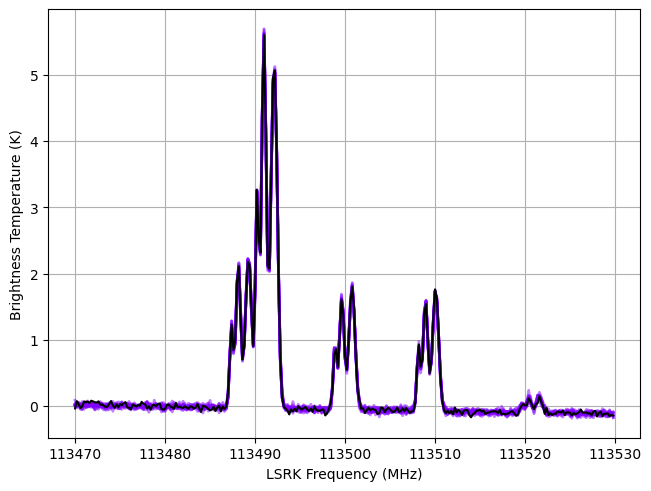

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 0.02}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = 10,487
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, log10_N0_norm, log10_Tkin_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 141 seconds.


Adding log-likelihood to trace


Output()

There were 20 divergences in converged chains.
Runtime: 2.85 minutes


In [14]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [15]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
log10_N0[0]                   13.502  0.008  13.487   13.517      0.000   
log10_N0[1]                   13.181  0.011  13.161   13.200      0.000   
log10_N0[2]                   12.803  0.020  12.769   12.840      0.000   
log10_Tkin[0]                  1.195  0.012   1.173    1.219      0.000   
log10_Tkin[1]                  2.019  0.138   1.780    2.277      0.003   
log10_Tkin[2]                  1.893  0.197   1.538    2.256      0.004   
log10_Tex_mean[0]              1.195  0.012   1.173    1.219      0.000   
log10_Tex_mean[1]              2.019  0.138   1.780    2.277      0.003   
log10_Tex_mean[2]              1.893  0.197   1.538    2.256      0.004   
log10_N[0]                    14.172  0.005  14.162   14.182      0.000   
log10_N[1]                    13.941  0.006  13.931   13.952      0.000   
log10_N[2]                    13.557  0.010  13.540   13.576      0.000   
velocity[0]                   -2.996  0.004  -3.003   -2.989      0.000   
velocity[1]                   -0.003  0.004  -0.010    0.004      0.000   
velocity[2]                    2.000  0.006   1.989    2.011      0.000   
fwhm_thermal[0]                0.166  0.002   0.162    0.170      0.000   
fwhm_thermal[1]                0.435  0.074   0.320    0.570      0.002   
fwhm_thermal[2]                0.381  0.091   0.237    0.548      0.002   
fwhm_nonthermal[0]             1.980  0.011   1.959    2.000      0.000   
fwhm_nonthermal[1]             1.484  0.025   1.442    1.521      0.001   
fwhm_nonthermal[2]             0.993  0.042   0.917    1.053      0.001   
fwhm[0]                        1.987  0.011   1.966    2.007      0.000   
fwhm[1]                        1.548  0.012   1.525    1.570      0.000   
fwhm[2]                        1.068  0.015   1.040    1.096      0.000   
tau_total[0]                   1.371  0.057   1.260    1.474      0.001   
tau_total[1]                   0.119  0.037   0.055    0.191      0.001   
tau_total[2]                   0.070  0.032   0.017    0.129      0.001   
fwhm_L                         0.011  0.010   0.000    0.029      0.000   
baseline_observation_norm[0]  -1.004  0.075  -1.144   -0.863      0.001   
baseline_observation_norm[1]  -4.669  0.200  -5.049   -4.300      0.002   
baseline_observation_norm[2]   1.392  0.883  -0.284    3.013      0.011   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
log10_N0[0]                     0.000    4042.0    4458.0    1.0  
log10_N0[1]                     0.000    2680.0    1971.0    1.0  
log10_N0[2]                     0.000    2372.0    2496.0    1.0  
log10_Tkin[0]                   0.000    3938.0    4110.0    1.0  
log10_Tkin[1]                   0.002    2649.0    2275.0    1.0  
log10_Tkin[2]                   0.003    2334.0    1786.0    1.0  
log10_Tex_mean[0]               0.000    3938.0    4110.0    1.0  
log10_Tex_mean[1]               0.002    2649.0    2275.0    1.0  
log10_Tex_mean[2]               0.003    2334.0    1786.0    1.0  
log10_N[0]                      0.000    4222.0    4552.0    1.0  
log10_N[1]                      0.000    2844.0    2456.0    1.0  
log10_N[2]                      0.000    2692.0    4128.0    1.0  
velocity[0]                     0.000    8520.0    5558.0    1.0  
velocity[1]                     0.000    7129.0    5510.0    1.0  
velocity[2]                     0.000    6591.0    5348.0    1.0  
fwhm_thermal[0]                 0.000    3938.0    4110.0    1.0  
fwhm_thermal[1]                 0.001    2649.0    2275.0    1.0  
fwhm_thermal[2]                 0.002    2334.0    1786.0    1.0  
fwhm_nonthermal[0]              0.000    6312.0    5753.0    1.0  
fwhm_nonthermal[1]              0.000    3017.0    1969.0    1.0  
fwhm_nonthermal[2]              0.001    2435.0    1796.0    1.0  
fwhm[0]                         0.000    6216.0    5709.0    1.0  
fwhm[1]                         0.000    6600.0    6619.0    1.0  
fwhm[2]                

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [observation]


Output()

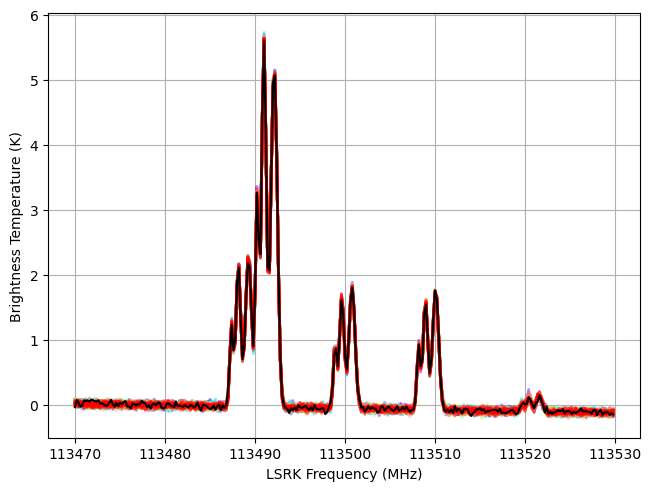

In [16]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

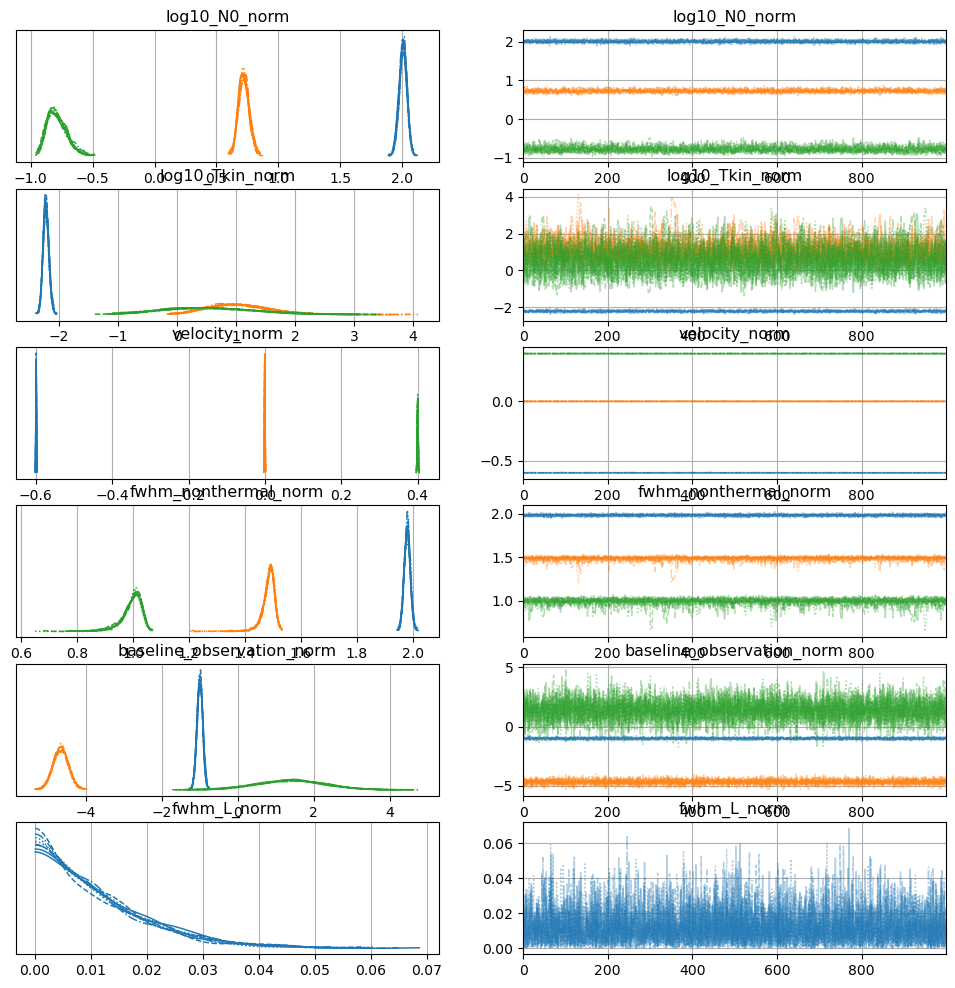

In [17]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

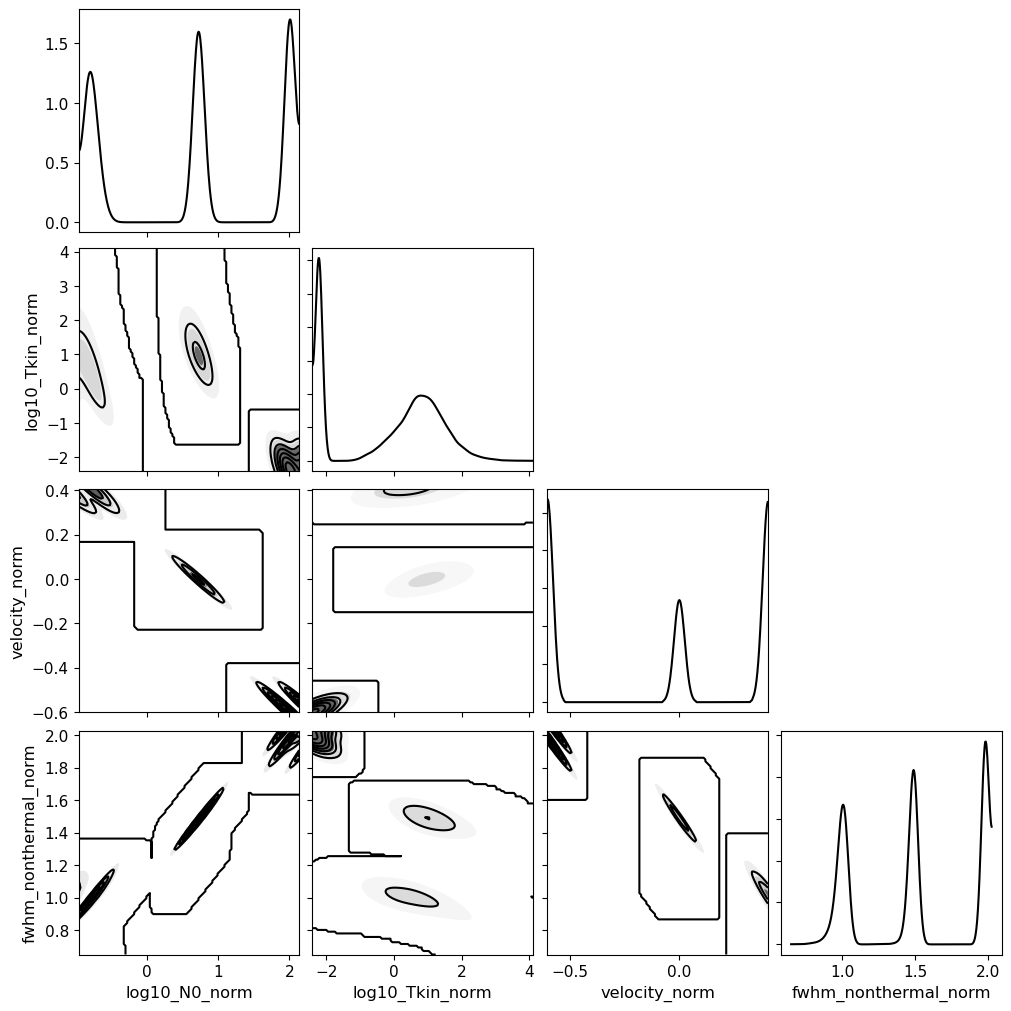

In [18]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_freeRVs, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the transition and state dependent parameters for clarity) along with the model hyper-parameters.

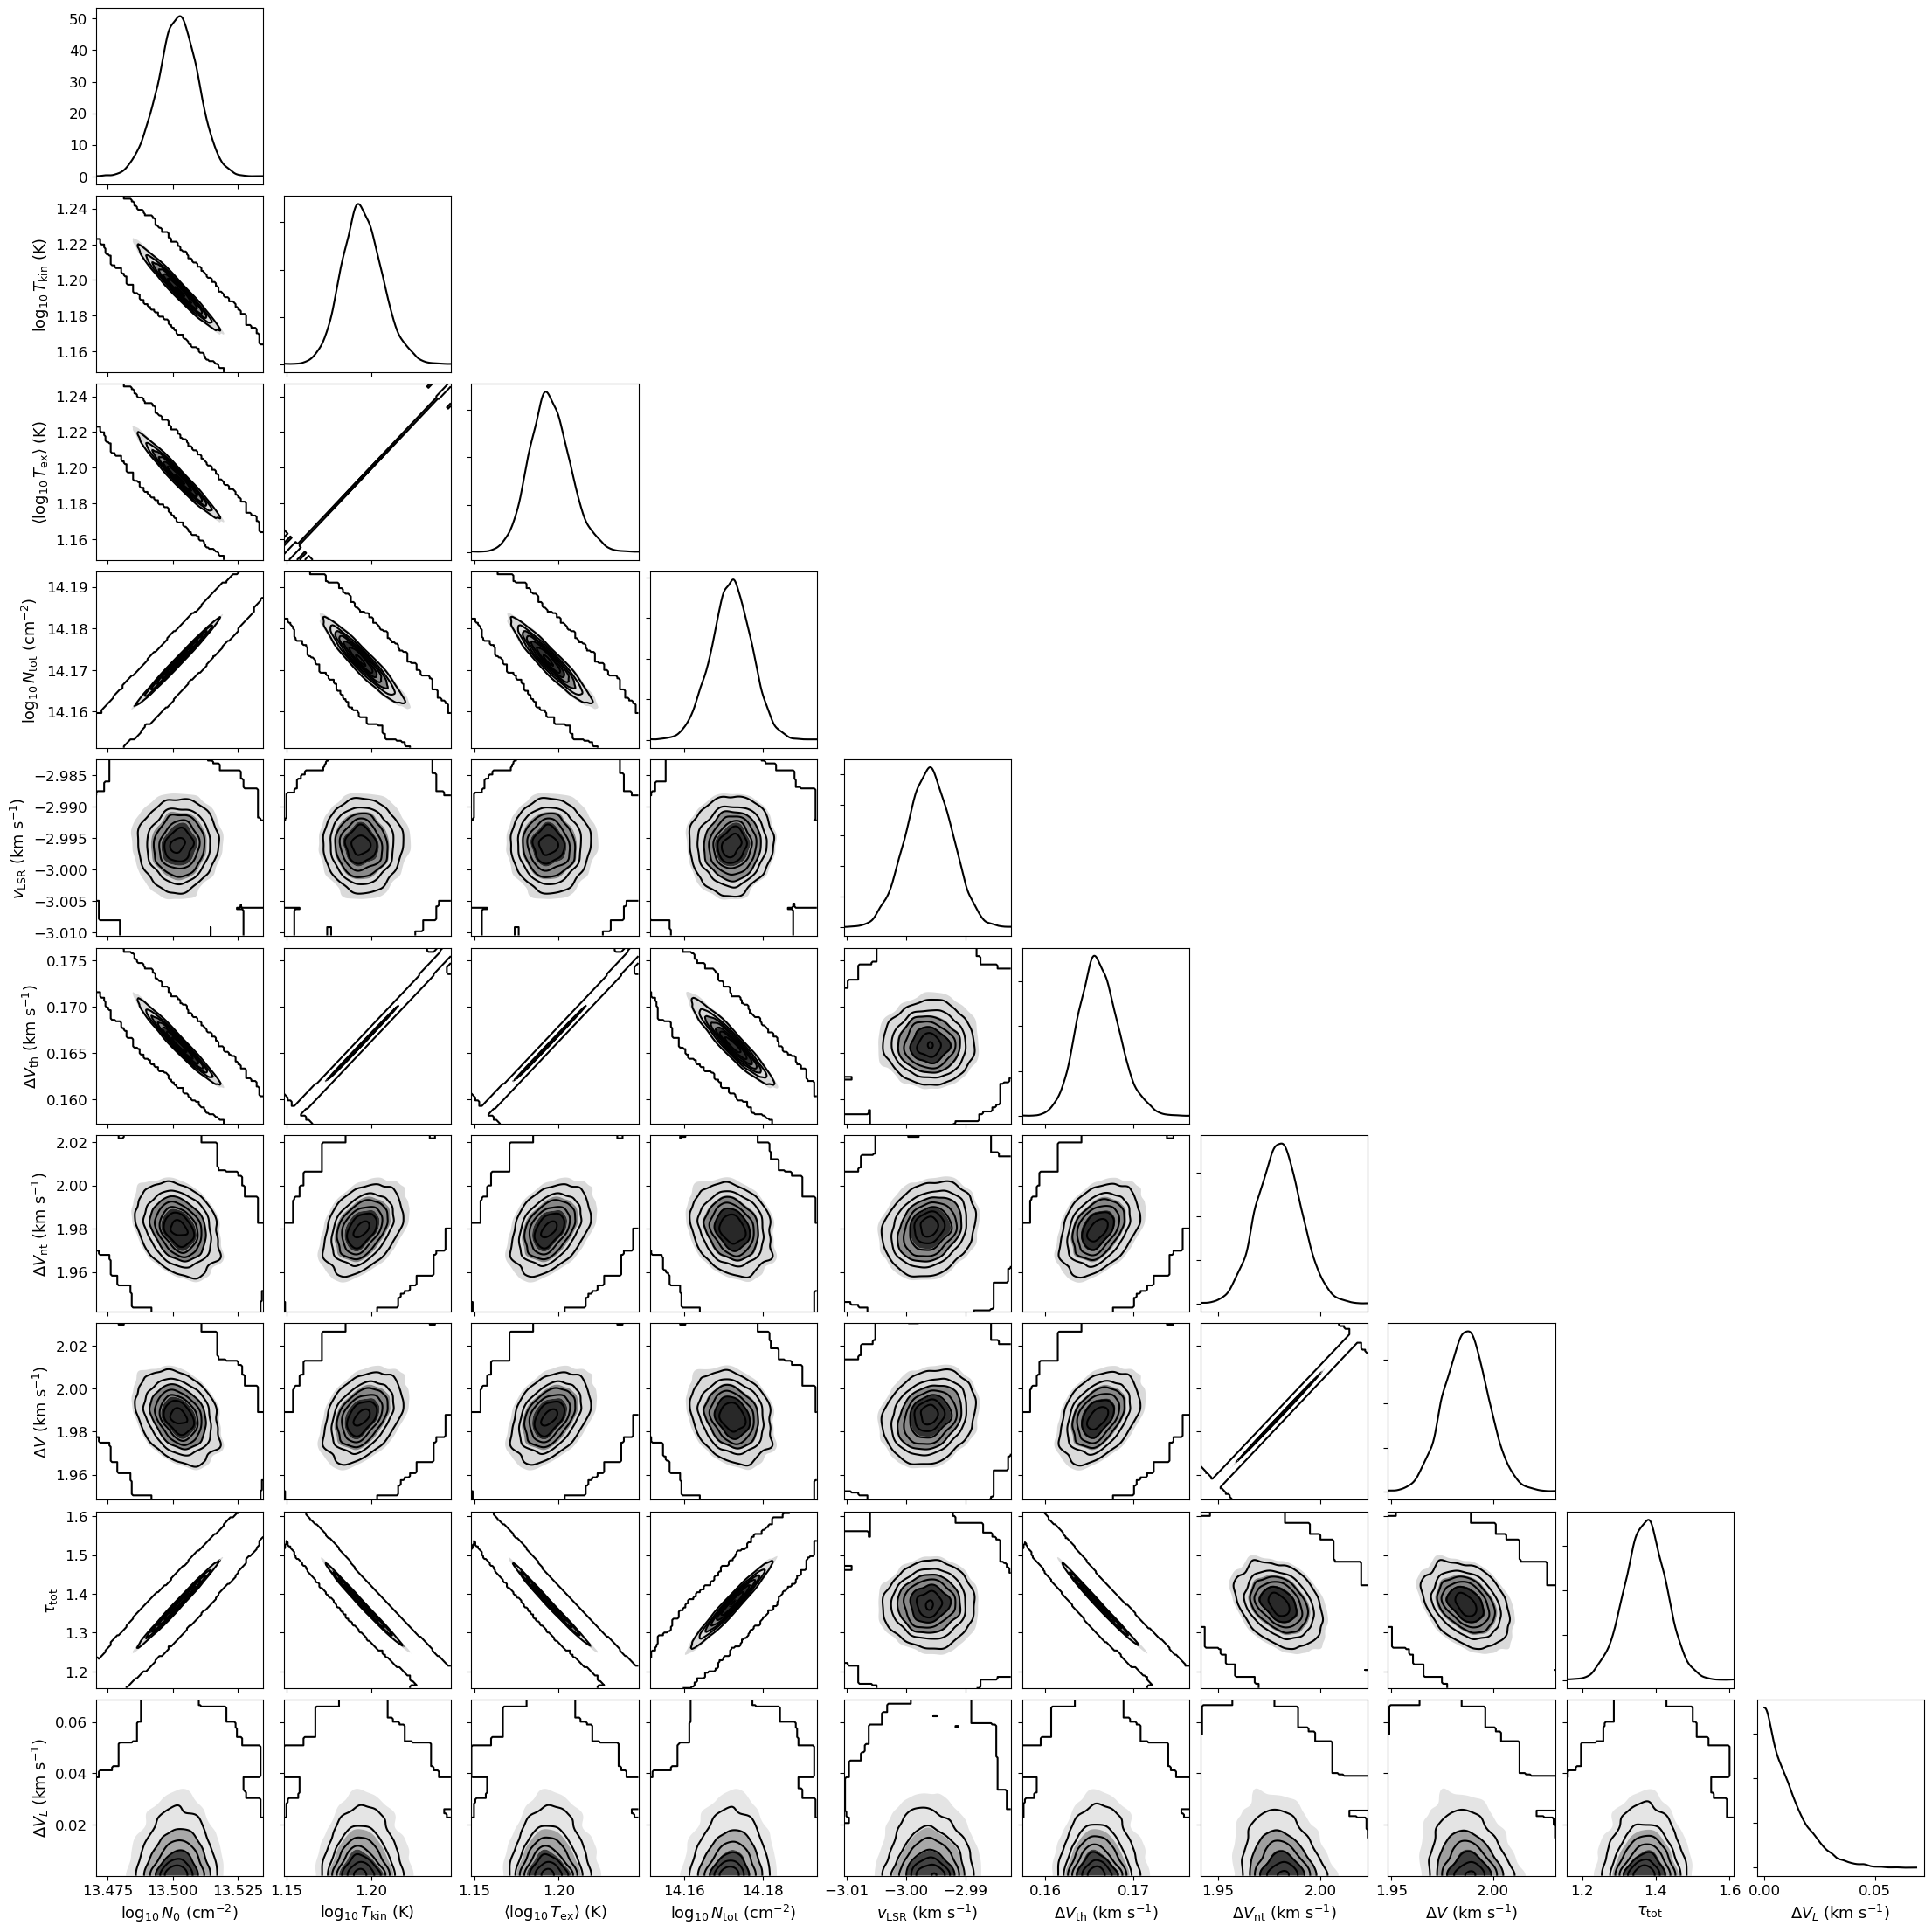

In [19]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
axes = plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
_ = axes.ravel()[0].figure.savefig("cn_model_posterior_0.png")

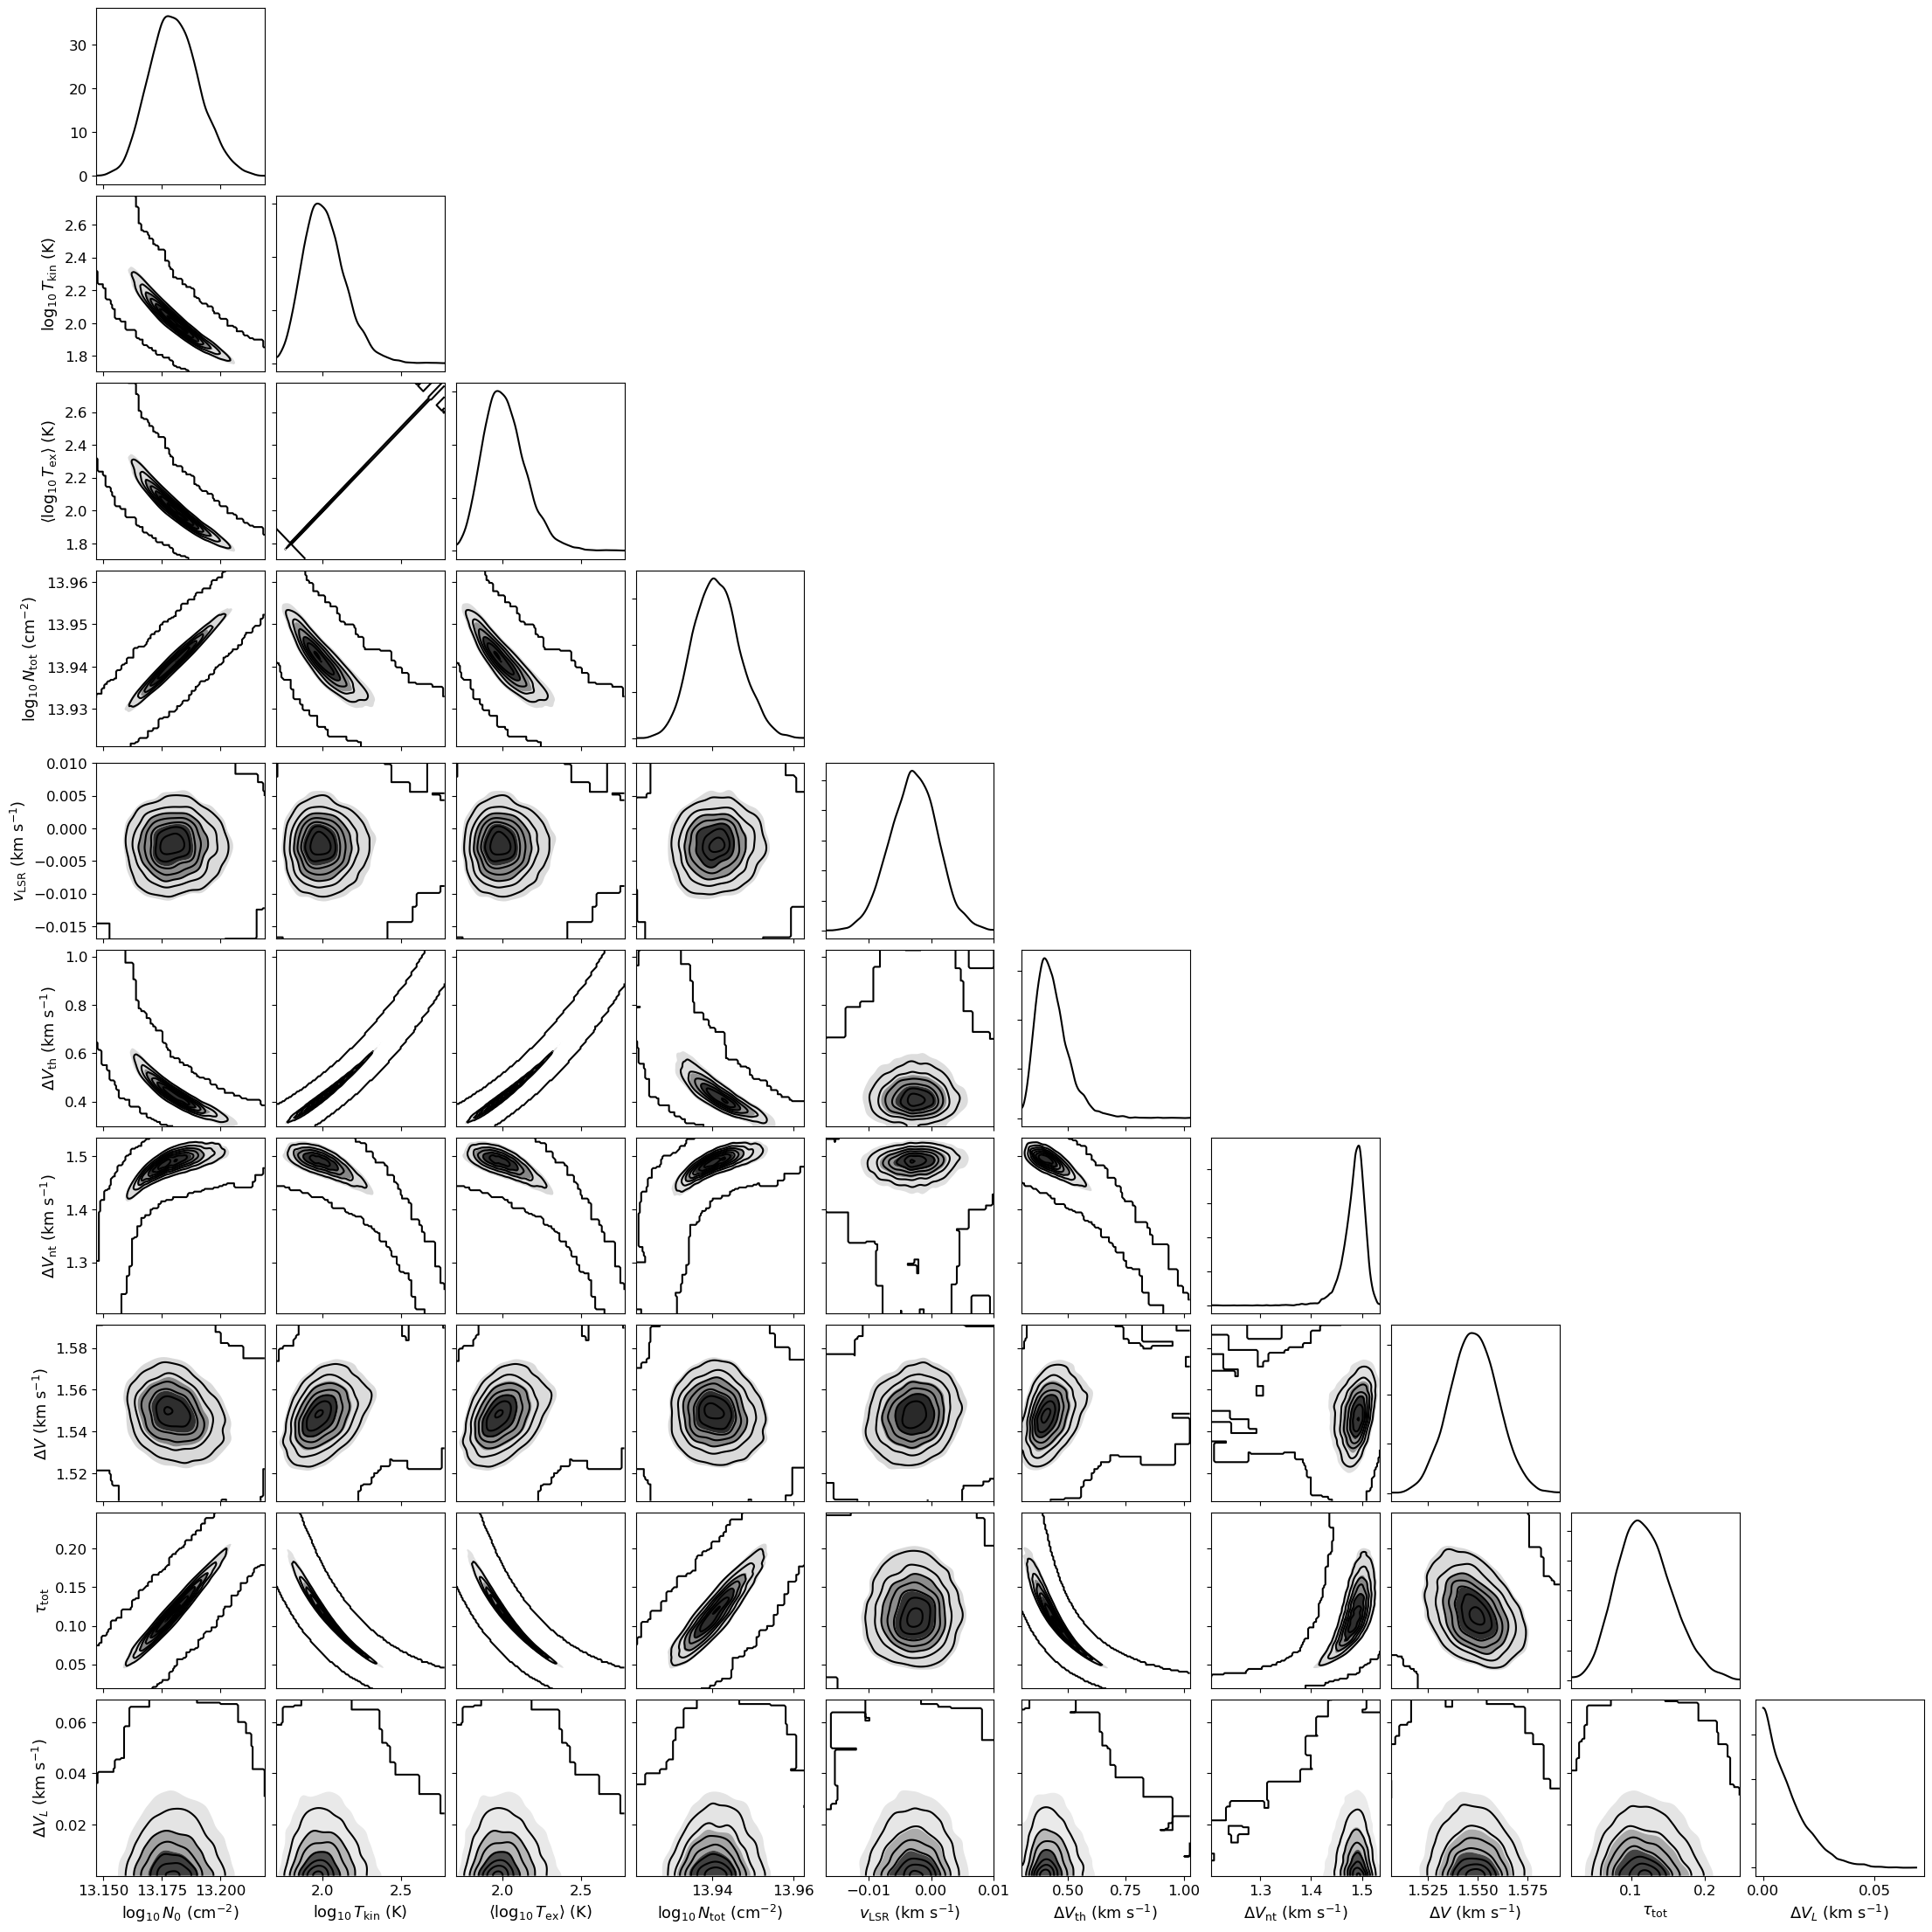

In [20]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)

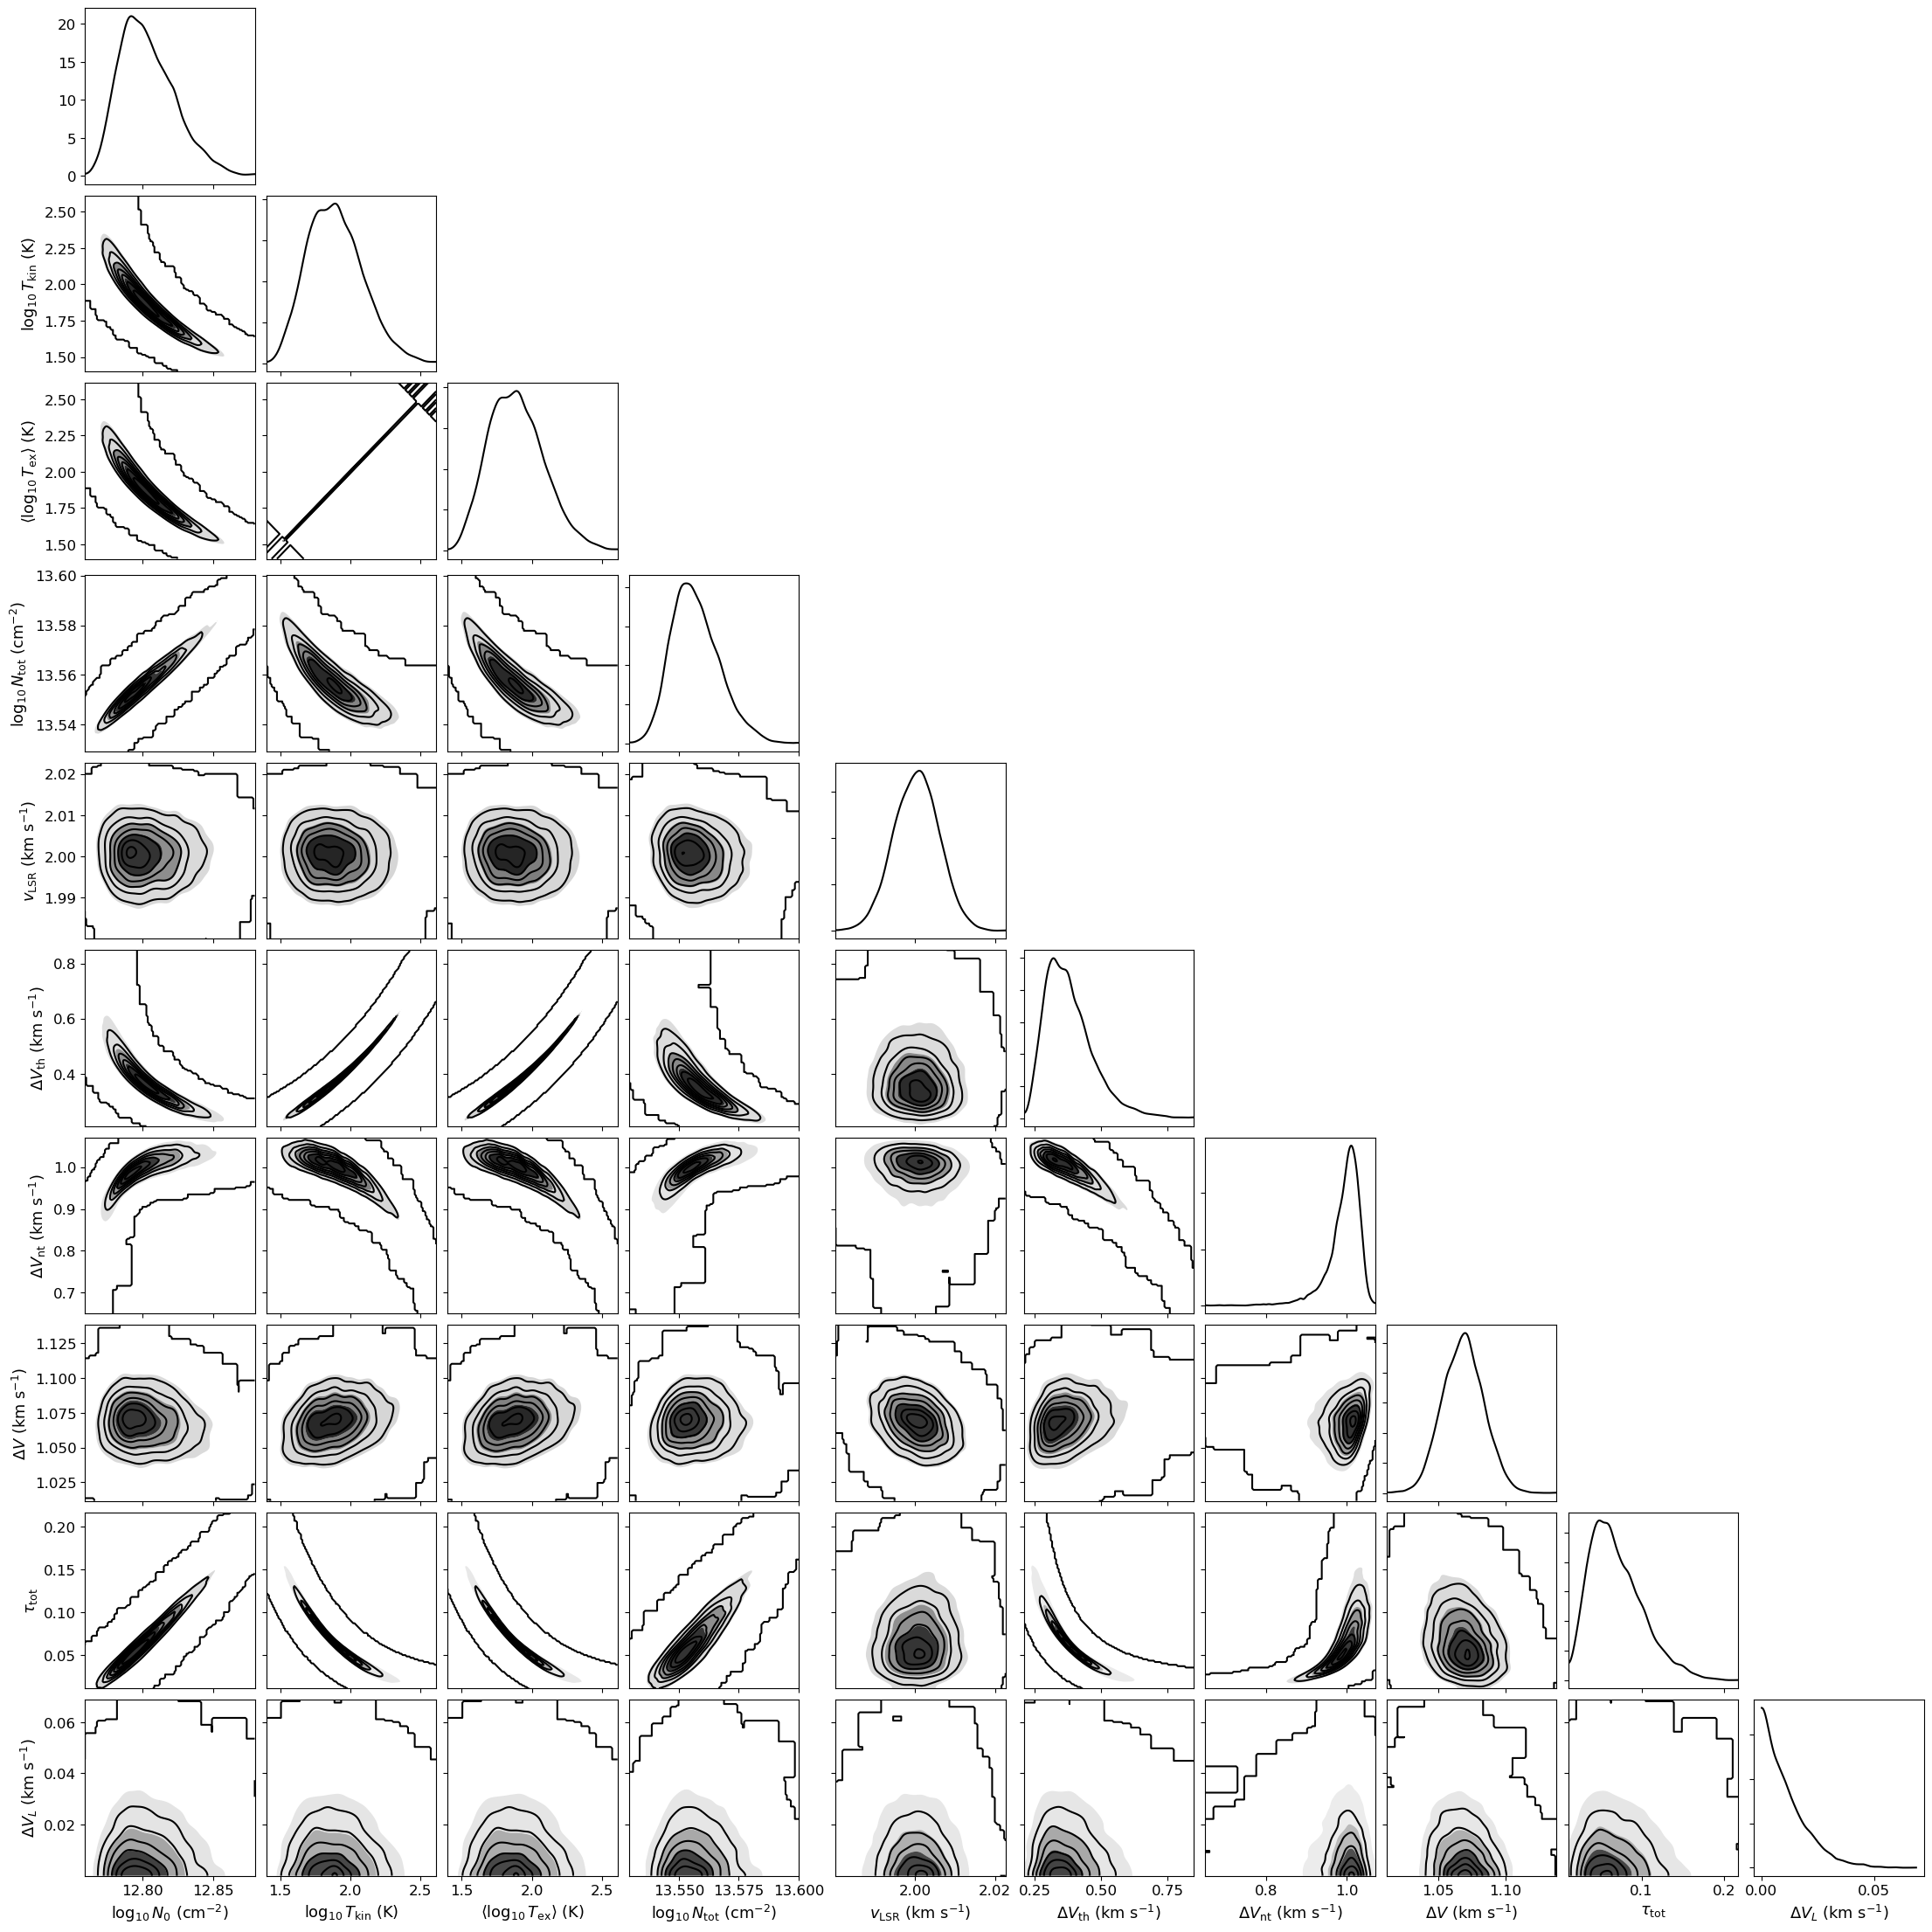

In [21]:
axes = plot_pair(
    model.trace.solution_0.sel(cloud=2), # samples
    var_names + model.hyper_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
)
_ = axes.ravel()[0].figure.savefig("cn_model_posterior_2.png")

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [22]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_deterministics
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -1141.506454815396


mean      sd  hdi_16%  hdi_84%
log10_N0[0]                        13.502   0.008   13.495   13.510
log10_N0[1]                        13.181   0.011   13.170   13.191
log10_N0[2]                        12.803   0.020   12.779   12.817
log10_Tkin[0]                       1.195   0.012    1.183    1.206
log10_Tkin[1]                       2.019   0.138    1.856    2.114
log10_Tkin[2]                       1.893   0.197    1.676    2.063
log10_Tex_mean[0]                   1.195   0.012    1.183    1.206
log10_Tex_mean[1]                   2.019   0.138    1.856    2.114
log10_Tex_mean[2]                   1.893   0.197    1.676    2.063
Tex[113123.3687, 0]                15.665   0.440   15.189   16.042
Tex[113123.3687, 1]               110.426  42.011   67.838  124.799
Tex[113123.3687, 2]                87.233  45.308   38.882  101.063
Tex[113144.19, 0]                  15.665   0.440   15.189   16.042
Tex[113144.19, 1]                 110.426  42.011   67.838  124.799
Tex[113144.19, 2]                  87.233  45.308   38.882  101.063
Tex[113170.535, 0]                 15.665   0.440   15.189   16.042
Tex[113170.535, 1]                110.426  42.011   67.838  124.799
Tex[113170.535, 2]                 87.233  45.308   38.882  101.063
Tex[113191.325, 0]                 15.665   0.440   15.189   16.042
Tex[113191.325, 1]                110.426  42.011   67.838  124.799
Tex[113191.325, 2]                 87.233  45.308   38.882  101.063
Tex[113488.142, 0]                 15.665   0.440   15.189   16.042
Tex[113488.142, 1]                110.426  42.011   67.838  124.799
Tex[113488.142, 2]                 87.233  45.308   38.882  101.063
Tex[113490.985, 0]                 15.665   0.440   15.189   16.042
Tex[113490.985, 1]                110.426  42.011   67.838  124.799
Tex[113490.985, 2]                 87.233  45.308   38.882  101.063
Tex[113499.643, 0]                 15.665   0.440   15.189   16.042
Tex[113499.643, 1]                110.426  42.011   67.838  124.799
Tex[113499.643, 2]                 87.233  45.308   38.882  101.063
Tex[113508.934, 0]                 15.665   0.440   15.189   16.042
Tex[113508.934, 1]                110.426  42.011   67.838  124.799
Tex[113508.934, 2]                 87.233  45.308   38.882  101.063
Tex[113520.4215, 0]                15.665   0.440   15.189   16.042
Tex[113520.4215, 1]               110.426  42.011   67.838  124.799
Tex[113520.4215, 2]                87.233  45.308   38.882  101.063
log_boltz_factor[113123.3687, 0]   -0.347   0.010   -0.357   -0.338
log_boltz_factor[113123.3687, 1]   -0.054   0.016   -0.068   -0.036
log_boltz_factor[113123.3687, 2]   -0.076   0.033   -0.097   -0.035
log_boltz_factor[113144.19, 0]     -0.347   0.010   -0.357   -0.338
log_boltz_factor[113144.19, 1]     -0.054   0.016   -0.068   -0.036
log_boltz_factor[113144.19, 2]     -0.076   0.033   -0.097   -0.035
log_boltz_factor[113170.535, 0]    -0.347   0.010   -0.357   -0.338
log_boltz_factor[113170.535, 1]    -0.054   0.016   -0.068   -0.036
log_boltz_factor[113170.535, 2]    -0.076   0.033   -0.097   -0.035
log_boltz_factor[113191.325, 0]    -0.347   0.010   -0.357   -0.338
log_boltz_factor[113191.325, 1]    -0.054   0.016   -0.068   -0.036
log_boltz_factor[113191.325, 2]    -0.076   0.033   -0.097   -0.035
log_boltz_factor[113488.142, 0]    -0.348   0.010   -0.358   -0.339
log_boltz_factor[113488.142, 1]    -0.055   0.016   -0.068   -0.036
log_boltz_factor[113488.142, 2]    -0.077   0.033   -0.098   -0.035
log_boltz_factor[113490.985, 0]    -0.348   0.010   -0.358   -0.339
log_boltz_factor[113490.985, 1]    -0.055   0.016   -0.068   -0.036
log_boltz_factor[113490.985, 2]    -0.077   0.033   -0.098   -0.035
log_boltz_factor[113499.643, 0]    -0.348   0.010   -0.358   -0.339
log_boltz_factor[113499.643, 1]    -0.055   0.016   -0.068   -0.036
log_boltz_factor[113499.643, 2]    -0.077   0.033   -0.098   -0.035
log_boltz_factor[113508.934, 0]    -0.348   0.010   -0.358   -0.339
log_boltz_factor[113508.9

In [23]:
print(sim_params)
print(derived_params)

{'log10_N0': [13.5, 13.2, 12.8], 'log10_Tkin': [1.2, 1.8, 1.9], 'fwhm_nonthermal': [2.0, 1.5, 1.0], 'velocity': [-3.0, 0.0, 2.0], 'fwhm_L': 0.0, 'baseline_observation_norm': [-2.0, -5.0, 8.0]}
{'log10_N': array([14.17137344, 13.95036441, 13.55602863]), 'tau_total': array([1.35016358, 0.19240919, 0.06138022])}
